# Retino-cortical map

## Point types

We start by defining the type of points we will use.

In [1]:
# Standard cartesian coordinates in the retinal plane
struct CartesianPoint{T<:Real}
    x::T
    y::T
end

CartesianPoint(x::Real, y::Real) = CartesianPoint(promote(x,y)...)

x(p::CartesianPoint) = p.x
y(p::CartesianPoint) = p.y

y (generic function with 1 method)

In [2]:
# Polar coordinates in the retinal plane
struct RetinalPoint{T<:Real} 
    r::T
    θ::T
end

RetinalPoint(r::Real, θ::Real) = RetinalPoint(promote(r,θ)...)

r(p::RetinalPoint) = p.r
θ(p::RetinalPoint) = p.θ

# Conversions cartesian <-> polar
Base.convert(::Type{RetinalPoint}, p::CartesianPoint; args...) = 
    RetinalPoint( sqrt( x(p)^2 + y(p)^2 ), atan(y(p), x(p)) )
Base.convert(::Type{CartesianPoint}, p::RetinalPoint; args...) = 
    CartesianPoint( r(p)*cos(θ(p)) , r(p)*sin(θ(p)) )

In [3]:
# Coordinates in the cortical plane
struct CorticalPoint{T<:Real} 
    x::T
    y::T
end

CorticalPoint(x::Real, y::Real) = CorticalPoint(promote(x,y)...)
x(p::CorticalPoint) = p.x
y(p::CorticalPoint) = p.y

y (generic function with 2 methods)

## Conversion formulas

Then we define the conversion formulas from the retinal to the cortical planes.

In [4]:
# retinal to cortical
Base.convert(::Type{CorticalPoint}, p::RetinalPoint; far_from_fovea = false) = 
            far_from_fovea ?  CorticalPoint(log(1+ r(p)) , (r(p)*θ(p))/(1+r(p))) : CorticalPoint(log(r(p)) , θ(p))

# cortical to retinal
function Base.convert(::Type{RetinalPoint}, p::CorticalPoint{T}; far_from_fovea = false) where T<:Real
    if iszero( x(p) )
        return RetinalPoint{T}(0,0)
    end
    r = far_from_fovea ?  exp(x(p))-1 : exp(x(p))
    far_from_fovea ? RetinalPoint( r , y(p)*( 1 + 1/r) ) : RetinalPoint( r , y(p))
end

# cartesian <-> cortical conversions
Base.convert(::Type{CorticalPoint}, p::CartesianPoint; args...) = 
            convert(CorticalPoint, convert(RetinalPoint, p; args...); args...)
Base.convert(::Type{CartesianPoint}, p::CorticalPoint; args...) = 
            convert(CartesianPoint, convert(RetinalPoint, p; args...))

## Converting an image from retinal to cortical

We will represent an image in the retinal plane as a function in the square $[-1,1]\times [-1,1]$. Let's find out to what part of the cortical plane this square corresponds:

In [5]:
a = zeros(200,200)

mesh(img) = [ CartesianPoint(x,y) for x in range(-10,10, length = size(img, 1)), y in range(-10,10, length = size(img, 2))]

x.(convert.(CorticalPoint, mesh(a))) |> extrema |> display
y.(convert.(CorticalPoint, mesh(a))) |> extrema |> display


# We should adjust the intervals for the inverse map (cort2res)
x.(convert.(CorticalPoint, mesh(a), far_from_fovea = true)) |> extrema |> display
y.(convert.(CorticalPoint, mesh(a), far_from_fovea = true)) |> extrema |> display

(-2.644146141450474, 2.649158683274018)

(-3.136567570258981, 3.136567570258981)

(0.06865442183481746, 2.7174812964321107)

(-2.8514283367165345, 2.8514283367165345)

We are ready to define the `res2cort` procedure.

In [6]:
using Images, ImageShow
using Interpolations

function fovea(img)
    xs = range(-1,1, length = size(img, 1))
    ys = range(-1,1, length = size(img, 2))
    eltype(img)[ xs[i]^2+ys[j]^2 < 1 ? img[i,j] : 1. for i in 1:length(xs), j in 1:length(ys)  ]
end

function res2cort(img; far_from_fovea = false)
    # Linear interpolation of starting image
    xs = range(-10,10, length = size(img, 1))
    ys = range(-10,10, length = size(img, 2))
    interp_linear = LinearInterpolation((xs, ys), transpose(convert.(Float64, img)), extrapolation_bc = Line())

    res = similar(img, Gray)
    xs = far_from_fovea ?  range(0.068, 2.717, length = size(img,1)) : range(-2.644, 2.649, length = size(img,1))
#    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-2.851, 2.851, length = size(img,2))
    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-3.136, 3.136, length = size(img,2))
    for i in 1:size(img,2), j in 1:size(img,1)
        p = convert(CartesianPoint, CorticalPoint(xs[i], ys[j]), far_from_fovea = far_from_fovea)
        res[j,i] =  convert(Gray, interp_linear(x(p), y(p)))
    end
    
    res
end

function cort2res(img; far_from_fovea = false)
    # Linear interpolation of starting image
    xs = far_from_fovea ?  range(0.068, 2.717, length = size(img,1)) : range(-2.644, 2.649, length = size(img,1))
    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-3.136, 3.136, length = size(img,2))
    interp_linear = LinearInterpolation((xs, ys), transpose(convert.(Float64, img)), extrapolation_bc = Line())

    res = similar(img, Gray)
    xs = range(-10,10, length = size(img, 1))
    ys = range(-10,10, length = size(img, 2))
    for i in 1:size(img,2), j in 1:size(img,1)
        p = convert(CorticalPoint, CartesianPoint(xs[i], ys[j]), far_from_fovea = far_from_fovea)
        res[j,i] =  convert(Gray, interp_linear(x(p), y(p)))
    end
    
    res
end

cort2res (generic function with 1 method)

A simple test.

# Comment on sigmoid $\sigma$

For MacKay pattern simulations, we take either $\sigma(r) = \tanh(r)$ or $\sigma(r) = \frac{r}{(1+|r|)}$ or any odd sigmoid function.

For Billock an Tsou simulations we take either $\sigma(r) = \frac{1}{1+\operatorname{e}^{-r+\gamma}}-\frac{1}{1+\operatorname{e}^\gamma}$ or any sigmoig function which is not an odd function but satisfies $\sigma(0) = 0$.

In [7]:
σ_1      = 0.1#0.51
σ_2      = 0.5#1.85
α        = 1
κ        = (σ_1/σ_2)^2*exp(2*pi^2*(σ_2^2-σ_1^2))
S(r)     = max(min(1,r),-1)
σ(r)     = 1/(1+exp(-r+0.25))-1/(1+exp(0.25)) #tanh(r), r/(1+abs(r))
ω(x,y)   = (1/(2π*σ_1^2))*exp(-(x^2+y^2)/(2*σ_1^2))-κ*(1/(2π*σ_2^2))*exp(-(x^2+y^2)/(2*σ_2^2)) 
ω_1(r)   = exp(-2*pi^2*σ_1^2*r^2)-κ*exp(-2*pi^2*σ_2^2*r^2)                   #Fourier transform of ω_1
q_0      = sqrt(log(κ*σ_2^2/σ_1^2)/(2π^2*(σ_2^2-σ_1^2)))
Θ        = σ_1*σ_2*sqrt(2*log(σ_2^2/(κ*σ_1^2))/(σ_2^2-σ_1^2))
C_1      = (1-κ)+2*(κ*exp(-0.5*Θ^2/σ_2^2)-exp(-0.5*Θ^2/σ_1^2))
μ        = 0.99*α/C_1
μ_0      = α/ω_1(q_0)
μ, α/C_1, μ_0          

(0.21518283891839976, 0.21735640294787856, 1.268980830389416)

In [8]:
# using OffsetArrays, ImageFiltering

# # U(x) = sqrt(7.32)*exp(-0.5*(x^2))
# # Us(Δx; L=1) = centered([U(x) for x in 0:Δx:L]) #converts an ordinary array to one that has coordinates at its center position
# # Ws(Δx, Δy; args...) = kernelfactors((Us(Δx; args...),Us(Δy; args...)))
# As(Δx; L=10) = centered([Δx^2*ω(x,y) for x in -L:Δx:L, y in -L:Δx:L ]) #it does the same thing that Ws(Δx, Δy; args...) but takes more time to execute imfilter than Ws(Δx, Δy; args...) 

In [9]:
using OffsetArrays, ImageFiltering#, PyPlot

As(Δx; L=10) = centered([Δx^2*ω(x,y) for x in -L:Δx:L, y in -L:Δx:L])

# function K(a, As; bc = :periodic)
#     if bc == :periodic
#         imfilter(a, reflect(As), "symmetric") #convolution not correlation
#     elseif bc == :dirichlet
#         imfilter(a, reflect(As),  Fill(0)) #convolution not correlation
#     end
# end
function K(a, As)
    imfilter(a,reflect(As),"reflect")
end
#An example to see that everything work fine :)
# a = [1 for x in -10:.01:10, y in -10:.01:10]
# b = K(a, As(.01))
# PyPlot.plot_surface(-10:.01:10, -10:.01:10, b)
# PyPlot.plot_surface(0:Δx:1, 0:Δx:1, K(a, As(Δx, Δx)))

K (generic function with 1 method)

# Stationary solution

In [10]:
using LinearAlgebra
function Ψ(I; Δx = .01, max_iter = 100, threshold = 1e-15)
    # As first step we take I
    prec = I
    ΨI = I
    # to keep track of final iteration
    final_iter = max_iter
    for i in 1:max_iter
        ΨI = (μ/α)*K(σ.(ΨI), As(Δx)) + I/α
        if norm(prec-ΨI, Inf) <= threshold
            final_iter = i
        break
        else
            prec = ΨI
        end
    end
    println("Total iterations: ", final_iter, ". Final precision: ", norm(prec-ΨI, Inf))
    println("Extrema of I: ", extrema(I), ", extrema of ΨI: ", extrema(ΨI))
    a        = [I[i,j]>0 ? 1 : 0 for i in 1:1:size(I,1), j in 1:1:size(I,1)]
    b        = [ΨI[i,j]>0 ? 1 : 0 for i in 1:1:size(ΨI,1), j in 1:1:size(ΨI,1)]
    A        = Gray.(rotl90(a)) 
    B        = Gray.(rotl90(b))
    A_1      = cort2res(A)
    B_1      = cort2res(B)
#     hcat(A, ones(Gray, (size(A,1),50)), A_1, ones(Gray, (size(A,1),50)), B, ones(Gray, (size(A,1),50)), B_1)
    hcat(A_1, ones(Gray, (size(A_1,1),50)), B_1)
#     hcat(A, ones(Gray, (size(A,1),50)), B)
end

Ψ (generic function with 1 method)

# MacKay effects

In [ ]:
# MacKay pattern for tunnel pattern

Δx       = .01
L        = 10
λ        = 2.5
f(x,y)   = cos(λ*2*pi*x)
Χ_1(x,y) = (-L ≤ x ≤ L) && ((-.25 ≤ y ≤ .25) || (9.75 ≤ y ≤ L) || (-L ≤ y ≤ -9.75)) ? 0.025 : 0.
v(x,y)   = f(x,y)+Χ_1(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]
Ψ(I, Δx=Δx)



In [ ]:
# MacKay pattern for funnel pattern

Δx       = .01
L        = 10
λ        = 2.5
f(x,y)   = cos(λ*2*pi*y)
Χ(x,y) = (-L ≤ x ≤ 2) && (-L ≤ y ≤ L) ? 0.025 : 0.
v(x,y)   = f(x,y)+Χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]
Ψ(I, Δx=Δx)


# Test Billock et Tsou

Total iterations: 18. Final precision: 4.440892098500626e-16
Extrema of I: (-1.0, 1.0), extrema of ΨI: (-1.0277780553236326, 1.0202897816105356)


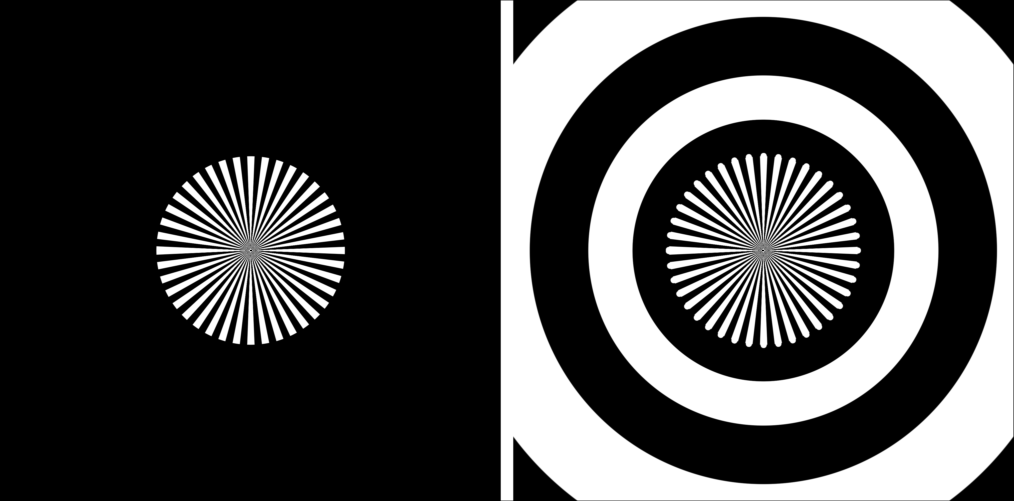

In [11]:
Δx       = .01
L        = 10
λ        = 2
f(x,y)   = cos(λ*2*pi*y)
Χ(x,y)   = (-L ≤ x ≤ 5) && (-L ≤ y ≤ L) ? 1 : 0.
v(x,y)   = f(x,y)*Χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]
 Ψ(I, Δx=Δx)

Total iterations: 100. Final precision: 0.0
Extrema of I: (-10.0, 10.0), extrema of ΨI: (-10.101444800456628, 10.03789966966861)


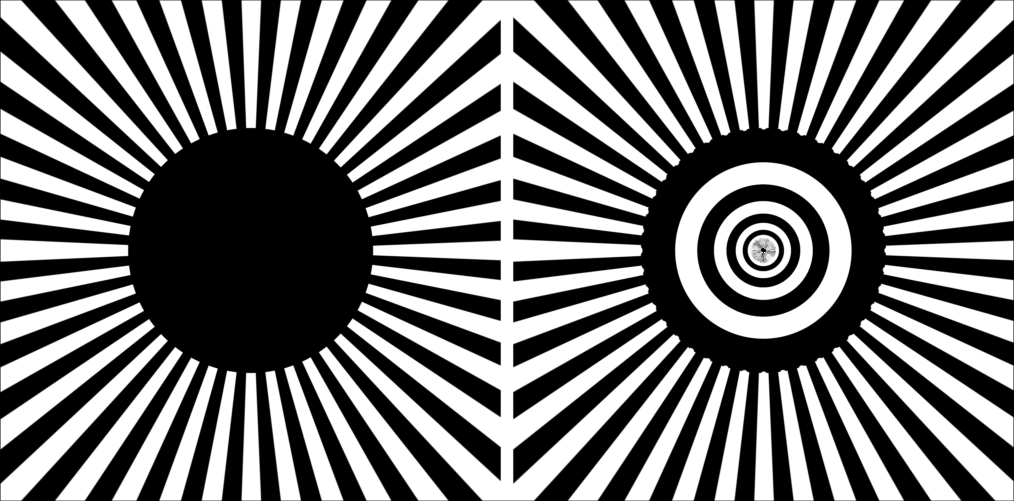

In [12]:
Δx       = .01
L        = 10
λ        = 2
f(x,y)   = 10*cos(λ*2*pi*y)
Χ(x,y)   = (6 ≤ x ≤ L) && (-L ≤ y ≤ L) ? 1 : 0.
v(x,y)   = f(x,y)*Χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]
 Ψ(I, Δx=Δx)

In [ ]:
Δx       = .01
L        = 10
λ        = 1
f(x,y)   = 0.5*cos(λ*2*pi*x)
Χ(x,y)  = (6 ≤ x ≤ L) && (-L ≤ y ≤ L) ? 1 : 0.  
v(x,y)   = f(x,y)*Χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]
 Ψ(I, Δx=Δx)

In [ ]:
Δx       = .01
L        = 10
λ        = 1
f(x,y)   = cos(λ*2*pi*x)
Χ(x,y)   = (-L < x ≤ 6) && (-L ≤ y ≤ L) ? 1. : 0.
v(x,y)   = f(x,y)*Χ(x,y)
I        = [v(x,y) for x in -L:Δx:L, y in -L:Δx:L]
 Ψ(I, Δx=Δx)